**Implementation of a SOTA research paper written on effect of Dropout Layers in improving model accuracy and robustness**

Dataset used here is the CIFAR-10 dataset constituting of 60000 image data of 10 everyday items. This is an attempt to implement the research paper titled "*Improving neural networks by preventing co-adaption of feature detectors*" authored by G. E. Hinton, N. Srivastava, A. Krizhevsky, I. Sutskever and R. R. Salakhutdinov. This paper dates back to 2012 and has citations from the very popular AlexNet research paper by Alex Krizhevsky.

A snippet from the website *paperswithcode*.

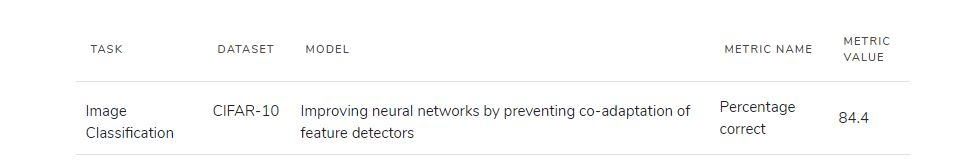

The accuracy levels achieved at the time of publishing was 84.4%. 
I've tried to recreate and achieve an accuracy as close to the original paper as possible.

Link to the webpage: https://paperswithcode.com/paper/improving-neural-networks-by-preventing-co

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
''' This imports the CIFAR-10 dataset from https://www.cs.toronto.edu/~kriz/cifar.html'''
from keras.datasets import cifar10   
import matplotlib.cm as cm
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
'''Making sure all datasets are numpy arrays'''
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x  = np.array(test_x)
test_y  = np.array(test_y)

In [ ]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
train_y.shape

(50000, 1)

In [ ]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
test_y.shape

(10000, 1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


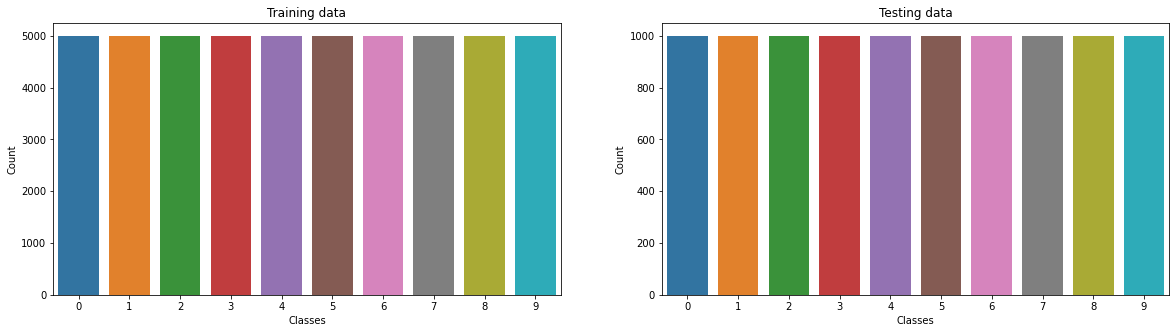

In [ ]:
import seaborn as sns

'''To check for any inconsistencies in the dataset which might affect the model
towards being more biased.'''

plt.figure(figsize=(20,5))
plt.subplot(1,2,1) 
# Count plot for training set
sns.countplot(train_y.ravel())
plt.title('Training data')
plt.xlabel('Classes')
plt.ylabel('Count')

plt.subplot(1,2,2)
# Count plot for testing set
sns.countplot(test_y.ravel())
plt.title('Testing data')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [ ]:
# Check for available GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


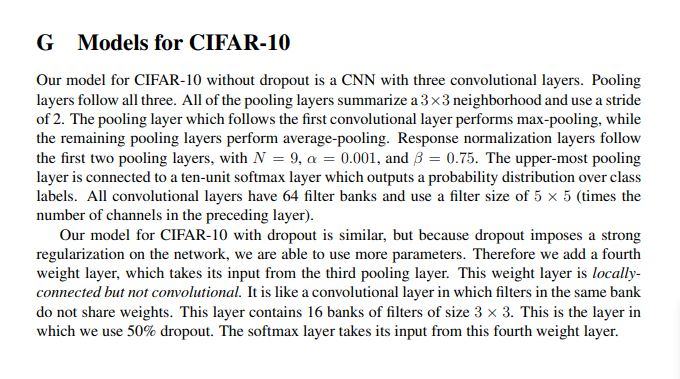

This is a snippet from the paper titled "Improving neural networks by preventing
co-adaptation of feature detectors". Find the paper [here](https://arxiv.org/pdf/1207.0580.pdf).

Modifications that I made while implementing the paper:

- instead of Local response normalization I've used Batch normalization.
- since 0.5 dropout was shutting down necessary neurons too and affecting the accuracy aswell, I used a 0.4 dropout instead.

In [ ]:
import matplotlib.colors

In [ ]:
def AlexNet(training_images_x, training_images_y):
  with tf.device(device_name):

    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv2D(64,(5,5), padding='same',activation=tf.nn.relu, input_shape = (training_images_x[0].shape)),
        tf.keras.layers.MaxPooling2D(3,2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(64,(5,5),padding='same',activation=tf.nn.relu),
        tf.keras.layers.AveragePooling2D(3,2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(64,(5,5), padding='same',activation=tf.nn.relu),
        tf.keras.layers.AveragePooling2D(3,2),

        tf.keras.layers.LocallyConnected2D(16,(3,3), strides=(1, 1), padding='valid', activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation = tf.nn.softmax),
        
        ])
    
    def scheduler(epoch):
      '''This functions reduces the learning rate by a factor of 10 twice before 
      training comes to an end. This is effective in terms of minimizing the 
      Loss function'''

      if epoch < 60:
        return 0.001
      elif epoch < 70:
        return 0.001/10
      else:
        return 0.001/100

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

    '''This callback automatically stops training once the accuracy 
    starts saturating.'''
    monitor = tf.keras.callbacks.EarlyStopping(
              monitor='accuracy', min_delta=0.0002, patience=5, verbose=1, mode='auto',
              baseline=None, restore_best_weights=False
              )

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    history = model.fit(
          training_images_x, training_images_y, epochs = 100, callbacks = [monitor, lr_scheduler]
     )
    print(model.summary())

    '''Plot for Loss function of the model'''
    plt.figure(figsize=(10,5.6))
    plt.title("Loss function through epochs")
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(linestyle='-', linewidth=2)
    plt.xlim([-5, 100])
    plt.ylim([0, 2.2])
    plt.show()

    '''Plot for training Accuracy of the model'''
    plt.figure(figsize=(10,5.6))
    plt.title("Accuracy through epochs")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(linestyle='-', linewidth=2)
    plt.xlim([-5, 100])
    plt.ylim([0.2, 1.0])
    plt.show()


    '''Following code plots and visualizes the various convolution filters that 
    the data goes through. These filters change overtime and each filter learns 
    to activate for certain features of the input image.'''
    
    conv_layer_postions = [0,3,6]

    for l in conv_layer_postions:
      print("conv"+str(l+1)+" layer")
      filters, biases = model.layers[l].get_weights()
      # normalize filter values to 0-1 so we can visualize them
      f_min, f_max = filters.min(), filters.max()
      filters = (filters - f_min) / (f_max - f_min)
      n_filters, ix = 5, 1

      for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]
        # plot each channel separately
        for j in range(3):
        # specify subplot and turn of axis
          ax = plt.subplot(n_filters, 3, ix)
          ax.set_xticks([])
          ax.set_yticks([])
          plt.figure(figsize=(3,3))
          plt.imshow(f[:, :, j], cmap=matplotlib.colors.ListedColormap(sns.color_palette()))
          ix += 1
          plt.show()


    return model


In [ ]:
# One vs all classification
label_binrizer = LabelBinarizer()
train_y = label_binrizer.fit_transform(train_y)
test_y = label_binrizer.fit_transform(test_y)

In [ ]:
train_x = tf.dtypes.cast(train_x, tf.float32)
test_x = tf.dtypes.cast(test_x, tf.float32)

In [ ]:
'''Makes the data center around zero'''
train_x = train_x/255
test_x = test_x/255

Epoch 1/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.9961 - accuracy: 0.2480 - lr: 0.0010
Epoch 2/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.7143 - accuracy: 0.3334 - lr: 0.0010
Epoch 3/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.6003 - accuracy: 0.3787 - lr: 0.0010
Epoch 4/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.4697 - accuracy: 0.4300 - lr: 0.0010
Epoch 5/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.3732 - accuracy: 0.4716 - lr: 0.0010
Epoch 6/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.2638 - accuracy: 0.5273 - lr: 0.0010
Epoch 7/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1534 - accuracy: 0.5806 - lr: 0.0010
Epoch 8/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0795 - accuracy: 0.6127 - lr: 0.0010
Epoch 9/100
1563/1563 [==============================] -

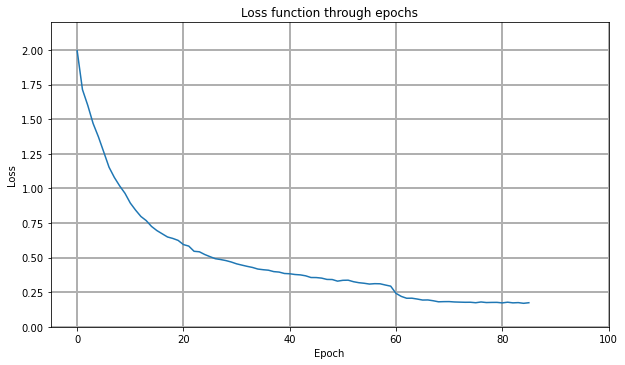

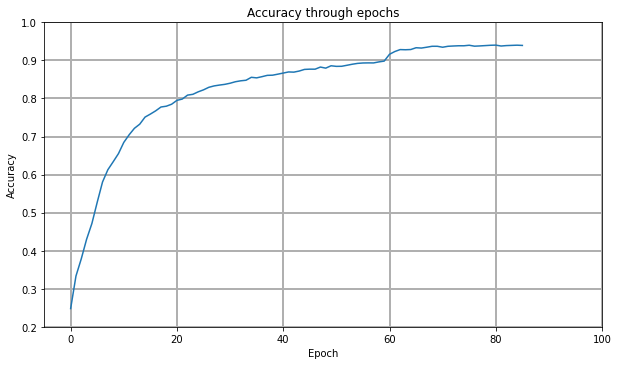

conv1 layer


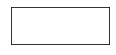

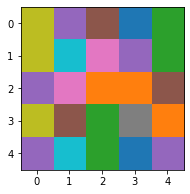

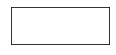

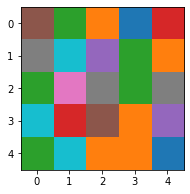

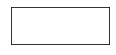

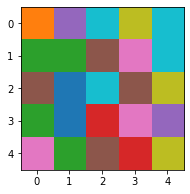

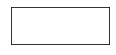

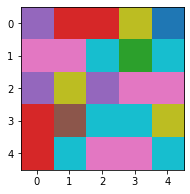

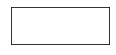

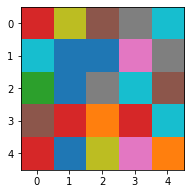

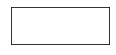

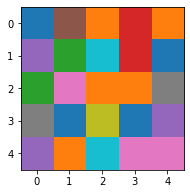

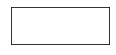

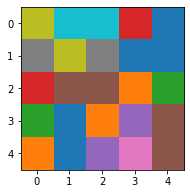

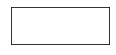

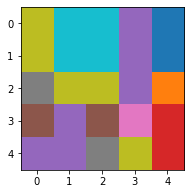

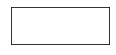

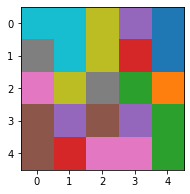

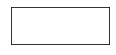

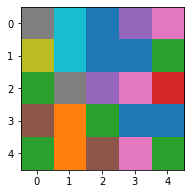

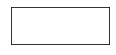

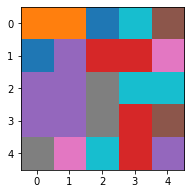

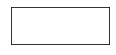

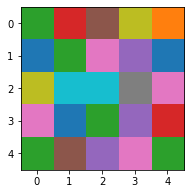

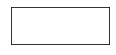

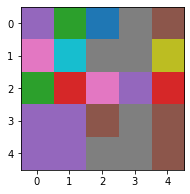

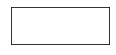

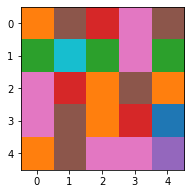

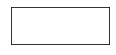

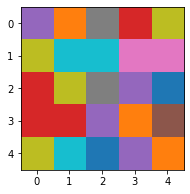

conv4 layer


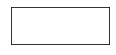

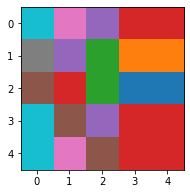

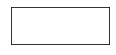

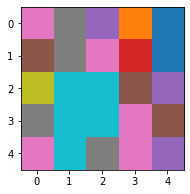

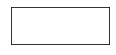

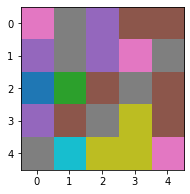

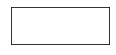

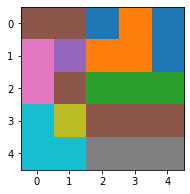

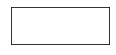

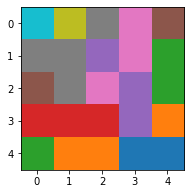

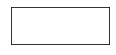

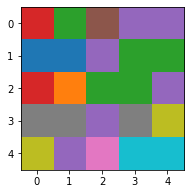

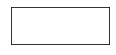

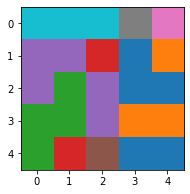

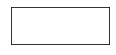

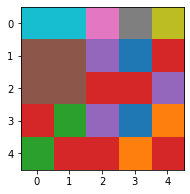

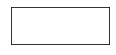

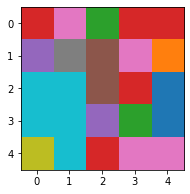

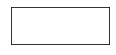

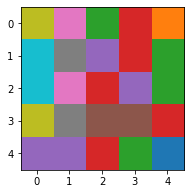

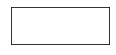

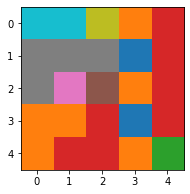

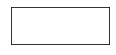

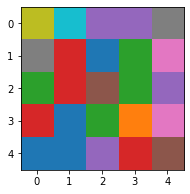

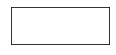

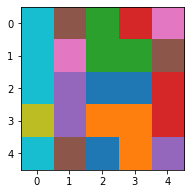

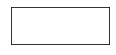

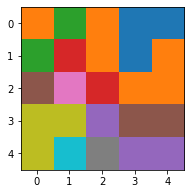

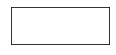

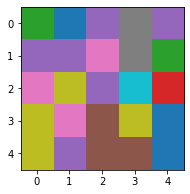

conv7 layer


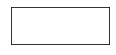

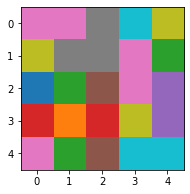

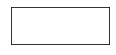

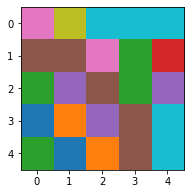

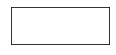

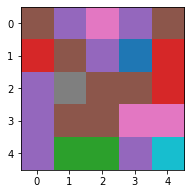

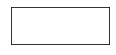

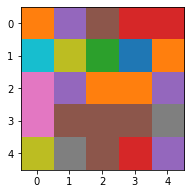

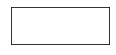

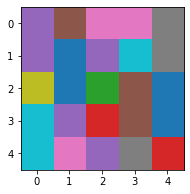

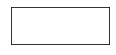

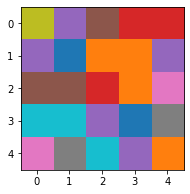

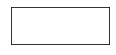

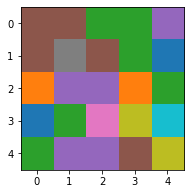

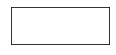

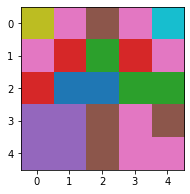

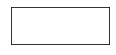

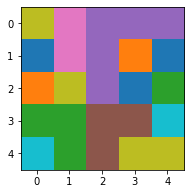

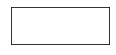

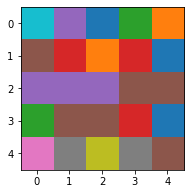

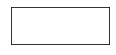

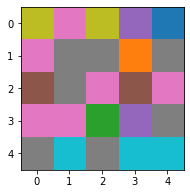

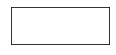

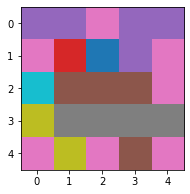

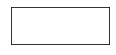

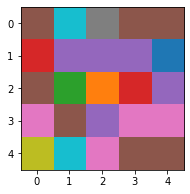

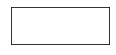

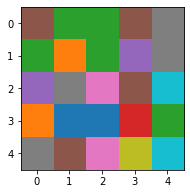

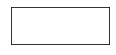

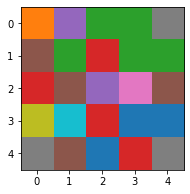

In [ ]:
model = AlexNet(train_x, train_y)

The model tries to minimize the loss function as it learns new parameters from the input image as it progresses through the number of epochs. This is evident from the *'Loss function through epochs'* graph. The loss function here keeps decreasing in value overtime in a desirable manner, which is a good sign indicating that the model fits the data well. 

This inturn increases model prediction accuracy, as evident from the *'Accuracy through epochs'* graph. 

Also, the weights of the model change as they get better at image recognition.
Some of the weight have been displayed here from the convolutional layers. This gives an interesting insight on what goes on with the layers inside the model during training. 

In [ ]:
model.evaluate(test_x, test_y, verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 1.4352 - accuracy: 0.7998


[1.4351513385772705, 0.7997999787330627]

About 80% test accuracy achieved.

In [ ]:
y_pred = model.predict(test_x)

In [ ]:
print('AlexNet test accuracy: ',accuracy_score(test_y, y_pred.round()))

AlexNet test accuracy:  0.7923


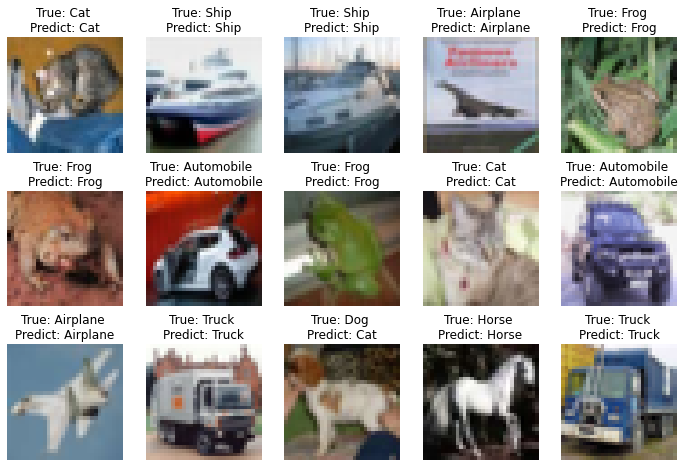

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

In [ ]:
'''Visualize correctly predicted images.'''

rows = 3
cols = 5
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_y, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = y_pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = test_x[errors]

fig, axes = plt.subplots(rows, cols, figsize=(12,8))
axes = axes.ravel()

for i in np.arange(0, rows*cols):
    plt.figure(figsize=(3,3))
    axes[i].imshow(test_x[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

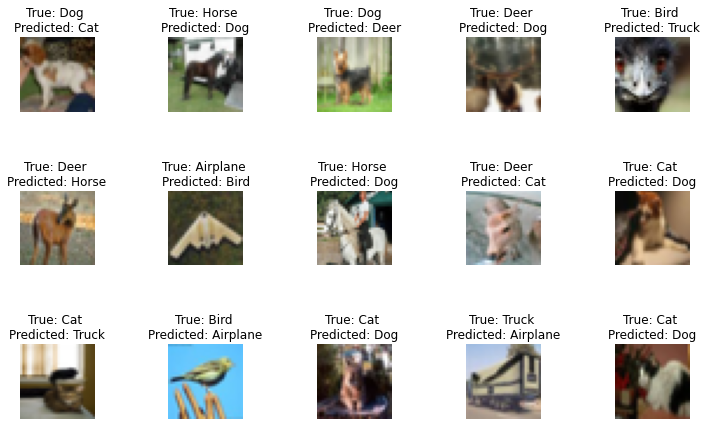

In [ ]:
'''Visualize incorrectly predicted images.'''

rows = 3
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, rows*cols):
    axes[i].imshow(test_x[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

                           ----------End of Notebook----------